# preprocess DR1 data

In [1]:
import os
import glob
import numpy as np 
import torch
import astropy.io.fits as fits
from astropy.table import Table, vstack

In [2]:
import matplotlib.pyplot as plt

In [3]:
qsos = Table.read('/global/cfs/cdirs/desi/public/dr1/survey/catalogs/dr1/QSO/iron/QSO_cat_iron_cumulative_v0.fits')

In [4]:
qsos

TARGETID,Z,ZERR,ZWARN,LOCATION,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,PROBA_RF,FLUX_IVAR_W2,MASKBITS,CMX_TARGET,DESI_TARGET,COADD_NUMEXP,COADD_EXPTIME,SV1_DESI_TARGET,SV2_DESI_TARGET,SV3_DESI_TARGET,SV1_SCND_TARGET,SV2_SCND_TARGET,SV3_SCND_TARGET,SCND_TARGET,TSNR2_LYA,TSNR2_QSO,DELTA_CHI2_MGII,A_MGII,SIGMA_MGII,B_MGII,VAR_A_MGII,VAR_SIGMA_MGII,VAR_B_MGII,Z_RR,Z_QN,C_LYA,C_CIV,C_CIII,C_MgII,C_Hbeta,C_Halpha,Z_LYA,Z_CIV,Z_CIII,Z_MgII,Z_Hbeta,Z_Halpha,QSO_MASKBITS,TILEID,LASTNIGHT,PETAL_LOC,SURVEY,PROGRAM,MORPHTYPE,SPECTYPE
,,,,,,deg,deg,mag,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,,,,,,,nanomaggy^-2,,,,,s,,,,,,,,,,,,Angstrom,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,int64,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,int16,int64,int64,int16,float32,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int64,int64,int64,bytes7,bytes6,bytes3,bytes6
39628488923152527,0.4042736047580836,1.0506833613982267e-05,0,156,0,24.024810111213217,30.48348181362247,0.058635194,12.279786,33.772457,71.58426,156.46507,154.8122,268.02426,30.578606,7.270935,1.0454626,0.8217694243918192,0.8217694243918192,0.8217694243918192,0.8217694243918192,0.8217694243918192,0.6914530617374693,0.3220765,0,72057594037929216,0,4,3600.0,0,0,0,0,0,0,0,208.6179,83.06355,76.36761,1.3562226,-29.136246,2.736289,0.0115362415,9.352602,0.0034880356,0.4042736,0.4021217,2.128966e-05,7.661322e-06,1.0119113e-05,0.99940515,0.9999831,0.9745881,2.3780172,2.3596458,1.3482288,0.40587068,0.4021217,0.40146056,32,80615,20201216,0,cmx,other,SER,QSO
39628483692860311,1.3774074908458118,0.0003531422702330532,0,233,0,23.973137768164488,30.320542989377977,0.056153137,1.0882326,1.9980105,2.2967024,12.576142,16.121857,1735.2317,426.53912,69.70505,2.833156,0.8286261863151821,0.8286261863151821,0.8286261863151821,0.8286261863151821,0.8286261863151821,0.9783768870830536,0.69374895,2048,36028797018968064,0,4,3600.0,0,0,0,0,0,0,0,214.5743,81.37831,83.61055,0.33592796,30.46155,0.6603624,0.0005682326,8.168998,0.00018945722,1.3774074,1.3750367,2.2185375e-05,0.99999034,0.99999976,1.0,1.2917763e-05,1.838905e-05,2.613432,1.373171,1.3770113,1.3750367,0.56382114,0.32121256,14,80615,20201216,0,cmx,other,PSF,QSO
39628488918960626,2.9200259600760345,0.0006097861343838982,0,186,0,23.967261403853023,30.42874560038731,0.058719844,0.7654192,1.138944,1.187339,4.73759,4.531618,1829.362,457.0536,70.354805,3.0913749,0.8215365798540586,0.8215365798540586,0.8215365798540586,0.8215365798540586,0.8215365798540586,0.9317171395123005,0.7162028,0,36028797018968064,0,4,3600.0,0,0,0,0,0,0,0,198.91277,82.66697,--,--,--,--,--,--,--,2.920026,2.9335732,0.9999808,0.9999631,0.9999968,0.0025587615,3.9186766e-06,9.933783e-06,2.9418852,2.941335,2.9335732,2.1329224,-0.159126,-0.14590475,10,80615,20201216,0,cmx,other,PSF,QSO
39628483692857098,0.40994924709431724,1.7655565932754103e-05,0,271,0,23.789290080149875,30.28367257963722,0.05613842,13.001515,40.989735,87.7768,132.00226,99.47504,129.58235,26.25261,4.8956194,0.69327843,0.828667017156222,0.828667017156222,0.828667017156222,0.828667017156222,0.828667017156222,0.09657152644955204,0.21058436,0,72057594037929216,0,4,3600.0,0,0,0,0,0,0,0,219.34567,84.65461,100.38362,1.3299135,23.536812,1.4741721,0.011587532,5.8908052,0.0023189934,0.40994924,0.41214192,1.8718843e-05,6.734884e-05,0.0031583968,0.95277846,0.69251776,0.44562832,2.5791543,2.2996085,1.102315,0.41214192,0.41432583,0.41801292,32,80615,20201216,0,cmx,other,DEV,QSO
39628488923152946,2.99591657426

# lets take a look a couple spectra

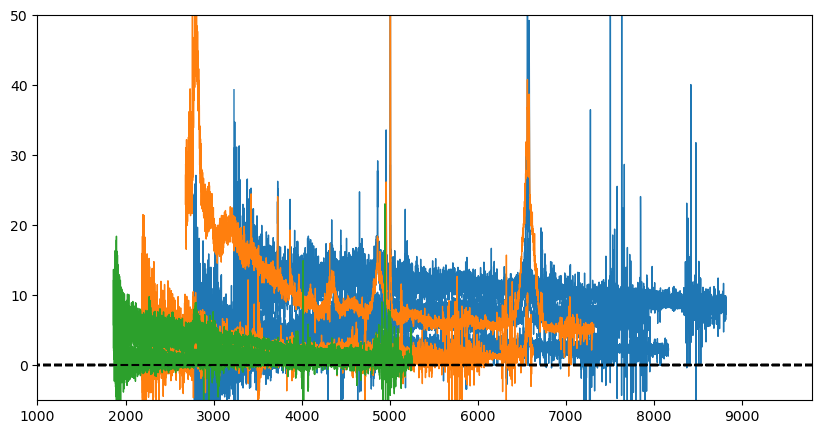

In [5]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii, zlow, zhigh in zip(np.arange(3), np.linspace(0., 1., 4)[:-1], np.linspace(0., 1., 4)[1:]): 
    zbin = (qsos['Z'] > zlow) & (qsos['Z'] < zhigh)

    for igal in np.random.choice(np.arange(len(qsos))[zbin], size=5): 
        fspec = os.path.join('/global/cfs/projectdirs/desi/spectro/redux/iron/tiles/cumulative', 
                             str(qsos['TILEID'][igal]), 
                             str(qsos['LASTNIGHT'][igal]), 
                             'coadd-%i-%i-thru%i.fits' % (qsos['PETAL_LOC'][igal], qsos['TILEID'][igal], qsos['LASTNIGHT'][igal]))

        hdulist = fits.open(fspec)
        meta = Table.read(fspec) # meta data
        target_id = hdulist[1].data['TARGETID'] # unique target ID

        is_gal = (target_id == qsos['TARGETID'][igal])
        assert np.sum(is_gal) == 1

        sub.plot(hdulist[3].data/(1+qsos['Z'][igal]), hdulist[4].data[is_gal][0], lw=1, c='C%i' % ii)
        sub.plot(hdulist[8].data/(1+qsos['Z'][igal]), hdulist[9].data[is_gal][0], lw=1, c='C%i' % ii)
        sub.plot(hdulist[13].data/(1+qsos['Z'][igal]), hdulist[14].data[is_gal][0], lw=1, c='C%i' % ii)
        sub.plot([0., 1e4], [0., 0.], ls='--', c='k') 
sub.set_xlim(1e3, 9.8e3)
sub.set_ylim(-5, 50)
plt.show()

# preprocess spectra

In [6]:
from spenderq import desi_qso

In [7]:
desiQSO = desi_qso.DESI()

In [21]:
def prepare_spectra(tileid, ipetal, qso): #, zbin='high'): 
    ''' prepare QSO spectra in a tile 
    '''
    # read co-add. These are cumulative exposures based on TILEID
    dir_tile = os.path.join('/global/cfs/projectdirs/desi/spectro/redux/iron/tiles/cumulative', str(tileid))
    assert len(glob.glob(dir_tile+'/*')) == 1

    night = glob.glob(dir_tile+'/*')[0].split('/')[-1]
    dir_coadd = os.path.join(dir_tile, night) 

    fspec = os.path.join(dir_coadd, 'coadd-%i-%i-thru%s.fits' % (ipetal, tileid, night))
    assert os.path.isfile(fspec)
   
    # read spectra file
    hdulist = fits.open(fspec)
    meta = Table.read(fspec) # meta data
    target_id = hdulist[1].data['TARGETID'] # unique target ID

    keep = np.zeros(len(meta)).astype(bool)
    z, zerr = np.zeros(len(meta)), np.zeros(len(meta))

    qso_tile = qso[(qso['TILEID'] == tileid)]
    for targetid, _z, _zerr in zip(qso_tile['TARGETID'], qso_tile['Z'], qso_tile['ZERR']): 
        keep = keep | (target_id == targetid)
        z[target_id == targetid] = _z
        zerr[target_id == targetid] = _zerr
    
    # read in data
    _wave, _flux, _ivar, _mask, _res = {}, {}, {}, {}, {}
    for h in range(2, len(hdulist)):
        if "WAVELENGTH" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _mask[band] = hdulist[h].data
        if "RESOLUTION" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _res[band] = hdulist[h].data
    # coadd the b, r, z arm spectra (scraped from
    # https://github.com/desihub/desispec/blob/main/py/desispec/coaddition.py#L529)
    tolerance = 0.0001  # A , tolerance
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])
    nwave = wave.size
    ntarget = _flux["b"].shape[0]
    check_agreement = torch.abs(torch.from_numpy(wave) - desiQSO._wave_obs)
    if check_agreement.max() > tolerance:
        print(
            "Warning: input wavelength grids inconsistent with class variable wave_obs!"
        )
    # check alignment, caching band wavelength grid indices as we go
    windict = {}
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windices = np.arange(imin, imin + len(_wave[b]), dtype=int)
        dwave = _wave[b] - wave[windices]

        if np.any(np.abs(dwave) > tolerance):
            msg = "Input wavelength grids (band '{}') are not aligned. Use --lin-step or --log10-step to resample to a common grid.".format(
                b
            )
            raise ValueError(msg)
        number_of_overlapping_cameras[windices] += 1
        windict[b] = windices

    # ndiag = max of all cameras
    ndiag = 0
    for b in ["b", "r", "z"]:
        ndiag = max(ndiag, _res[b].shape[1])

    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    ivar_unmasked = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    mask = np.zeros((ntarget, nwave), dtype=_mask["b"].dtype)
    rdata = np.zeros((ntarget, ndiag, nwave), dtype=_res["b"].dtype)

    for b in ["b", "r", "z"]:
        # indices
        windices = windict[b]

        band_ndiag = _res[b].shape[1]

        for i in range(ntarget):
            ivar_unmasked[i, windices] += np.sum(_ivar[b][i], axis=0)
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]
            for r in range(band_ndiag):
                rdata[i, r + (ndiag - band_ndiag) // 2, windices] += (
                    _ivar[b][i] * _res[b][i, r]
                )

            # directly copy mask where no overlap
            jj = number_of_overlapping_cameras[windices] == 1
            mask[i, windices[jj]] = _mask[b][i][jj]

            # 'and' in overlapping regions
            jj = number_of_overlapping_cameras[windices] > 1
            mask[i, windices[jj]] = mask[i, windices[jj]] & _mask[b][i][jj]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]
        ok = ivar_unmasked[i] > 0
        if np.sum(ok) > 0:
            rdata[i][:, ok] /= ivar_unmasked[i][ok]
            
    # apply bitmask, remove small values
    mask = mask.astype(bool) | (ivar <= 1e-6)
    ivar[mask] = 0

    # explicit type conversion to float32 to get to little endian
    spec = torch.from_numpy(flux[keep].astype(np.float32))
    w = torch.from_numpy(ivar[keep].astype(np.float32))
    target_id = torch.from_numpy(target_id[keep].astype(np.int64))

    # remove regions around skylines
    w[:, desiQSO._skyline_mask] = 0
    
    z = torch.tensor(z[keep].astype(np.float32))
    zerr = torch.tensor(zerr[keep].astype(np.float32))
    
    # normalize spectra:
    norm = torch.zeros(np.sum(keep))
    for i in range(np.sum(keep)):
        # for redshift invariant encoder: select norm window in restframe
        wave_rest = desiQSO._wave_obs / (1 + z[i])
        # wavelength range with no spectral lines
        # this wavelength range is set by the CIII absorprtion wavelengths. 
        # CIII absorption is small and thus should not contribute significantly
        # to estimating the normalization
        sel = (w[i] > 0) & (wave_rest > 1600) & (wave_rest < 1800) #(wave_rest > 5300) & (wave_rest < 5850)
        
        if sel.count_nonzero() > 0:
            norm[i] = torch.median(spec[i][sel])
        # remove spectra (from training) for which no valid norm could be found
        if not torch.isfinite(norm[i]):
            norm[i] = 0
        else:
            spec[i] /= norm[i]
        w[i] *= norm[i]**2

    # selects finite fluxes
    keep = (spec.isfinite().sum(axis=-1) == nwave).numpy()
    print("keep: %d / %d"%(keep.sum(),len(keep)))
    return spec[keep], w[keep], z[keep], target_id[keep],  norm[keep], zerr[keep]

split QSO data set into two redshift bins: z < 2.1 and 2.1 < z < 3.5

In [22]:
qso_highz = qsos[(qsos['Z'] > 2.1) & (qsos['Z'] < 3.5)]

In [23]:
len(qso_highz)

834951

In [25]:
spec, w, z, target_id, norm, zerr = prepare_spectra(80615, 0, qso_highz)

keep: 15 / 15


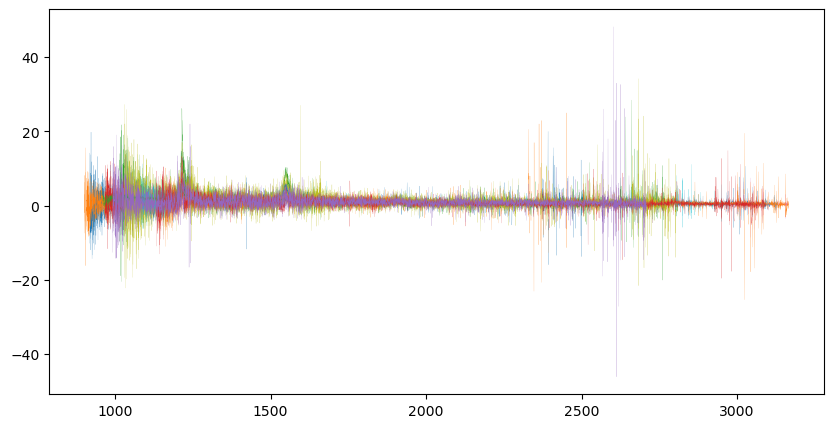

In [28]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for _spec, _z in zip(spec, z):
    sub.plot(desiQSO._wave_obs / (1 + _z), _spec, lw=0.1)

#sub.set_ylim(-10, 10)

In [ ]:
# save QSO spectra to batch
batch_size = 1024

counter, new_batch = 0, True
for tileid in np.unique(qso_highz['TILEID']): 
    petals = np.unique(qso_highz['PETAL_LOC'][qso_highz['TILEID'] == tileid])

    for ipetal in petals: 
        spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_highz)

        if new_batch:
            batches = [spec, w, z, target_id, norm, zerr]
            new_batch = False
        else:
            batches[0] = torch.concatenate([batches[0], spec], axis=0)
            batches[1] = torch.concatenate([batches[1], w], axis=0)
            batches[2] = torch.concatenate([batches[2], z], axis=0)
            batches[3] = torch.concatenate([batches[3], target_id], axis=0)
            batches[4] = torch.concatenate([batches[4], norm], axis=0)
            batches[5] = torch.concatenate([batches[5], zerr], axis=0)

        N = batches[0].shape[0]
        while N > batch_size:
            batch = [_batch[:batch_size] for _batch in batches]

            print(f"saving batch {counter}")
            desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso/train/dr1', batch, tag='.dr1.qsohiz', counter=counter)
            counter += 1
            N -= batch_size

            batches = [_batch[batch_size:] for _batch in batches]

# last lingering batch
batch = [_batch[:batch_size] for _batch in batches]
desiQSO.save_batch('/global/cfs/projectdirs/desi/users/chahah/spender_qso/train/dr1', batch, tag='.dr1.qsohiz', counter=counter)

keep: 24 / 24
keep: 32 / 32
keep: 27 / 27
keep: 25 / 25
keep: 23 / 23
keep: 33 / 33
keep: 27 / 27
keep: 16 / 16
keep: 26 / 26
keep: 27 / 27
keep: 19 / 19
keep: 22 / 22
keep: 30 / 30
keep: 28 / 28
keep: 18 / 18
keep: 31 / 31
keep: 28 / 28
keep: 24 / 24
keep: 29 / 29
keep: 20 / 20
keep: 22 / 22
keep: 26 / 26
keep: 36 / 36
keep: 24 / 24
keep: 25 / 25
keep: 32 / 32
keep: 20 / 20
keep: 14 / 14
keep: 24 / 24
keep: 23 / 23
keep: 27 / 27
keep: 36 / 36
keep: 29 / 29
keep: 24 / 24
keep: 21 / 21
keep: 29 / 29
keep: 24 / 24
keep: 16 / 16
keep: 32 / 32
keep: 20 / 20
keep: 19 / 19
saving batch 0
keep: 23 / 23
keep: 25 / 25
keep: 16 / 16
keep: 19 / 19
keep: 28 / 28
keep: 14 / 14
keep: 21 / 21
keep: 21 / 21
keep: 21 / 21
keep: 12 / 12
keep: 23 / 23
keep: 13 / 13
keep: 17 / 17
keep: 20 / 20
keep: 17 / 18
keep: 14 / 14
keep: 15 / 15
keep: 17 / 17
keep: 13 / 13
keep: 9 / 9
keep: 15 / 15
keep: 14 / 14
keep: 23 / 23
keep: 18 / 18
keep: 7 / 7
keep: 11 / 11
keep: 8 / 8
keep: 12 / 12
keep: 6 / 6
keep: 6 / 6
k